# Sparkify 项目 Workspace

预测用户流失率是数据科学家和分析师在面向消费者的一类公司中经常遇到的一项具有挑战性的问题。

本项目中，我们将尝试对在线音乐服务Sparkify的日志数据进行分析，以便有效预测用户流失情况。

所谓流失用户，我们通常定义为从收费用户降级至免费用户，以及直接取消服务的用户，这两部分用户也很可能有重合。本项目中，我们只对取消服务的用户作分析，即若用户日志的`page`字段中包含`Cancellation Confirmation`事件，我们就标记他们为流失用户（churn）。

我们的目标是从日志数据中抽取特征以建立一个模型，并拿它来预测测试集中的用户标签（churn），并和实际的标签对比。如果预测的结果至少优于基准值（Baseline），我们就可以认为这个模型是有用的。而若能得出有效预测，Sparkify平台就能够赶在用户取消服务之前给他们提供折扣或激励，以此降低流失率。

以下是本项目主要模块：

1.	加载和清洗数据
2.	探索性数据分析
3.	建立特征和标签
4.	训练和评估模型
5.	选择最优模型并调参
6.  解读

在探索性数据分析阶段，我们将主要使用可视化的方法对可能的影响因素逐一分析，以期找出流失和非流失用户表现不同的因素。因为待处理的数据量非常大，我们需要用到大数据工具 pyspark。

接下来我们就可以将候选因素作为`feature`、流失用户标签作为`label`建立模型，按 8:1:1 划分训练、验证和测试数据集，然后使用逻辑回归等多个机器学习模型，在训练集和验证集上进行训练，并对比训练结果（这里我们选用F1-Score为主要参考指标）。

最后对选中的模型进行调参，并在测试集上进行验证，以期获得最佳预测结果。同时我们也可以找出对用户流失影响最大的几个因素，看看他们是否与直觉相符。


In [2]:
# import general libraries
import datetime
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time

# import pyspark libraries
from pyspark.sql import SparkSession
from pyspark.sql.functions import udf, col, date_format, desc, max, min, round, expr, lit
from pyspark.sql.types import IntegerType

# import machine learning libraries
from pyspark.ml import Pipeline
from pyspark.ml.feature import StandardScaler, VectorAssembler, Normalizer
from pyspark.ml.regression import LinearRegression
from pyspark.ml.classification import LogisticRegression, RandomForestClassifier, GBTClassifier, LinearSVC, NaiveBayes
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder

In [3]:
# create a Spark session
spark = SparkSession \
    .builder \
    .appName('mini_sparkify_event_data') \
    .getOrCreate()

# 加载和清洗数据
完整的 Sparkify 日志数据集大小为 12GB，这里我们使用它的一个 128MB 的迷你子集`mini_sparkify_event_data.json`来进行分析。  
先加载和清洗数据集，并检查是否有无效或缺失数据

## 加载数据

In [4]:
path = ('mini_sparkify_event_data.json')
df = spark.read.json(path)

### 观察数据

In [5]:
# 字段及其数据类型一览
# 其中包括数个日期字段（如ts）需要转化为日期格式
df.printSchema()

root
 |-- artist: string (nullable = true)
 |-- auth: string (nullable = true)
 |-- firstName: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- itemInSession: long (nullable = true)
 |-- lastName: string (nullable = true)
 |-- length: double (nullable = true)
 |-- level: string (nullable = true)
 |-- location: string (nullable = true)
 |-- method: string (nullable = true)
 |-- page: string (nullable = true)
 |-- registration: long (nullable = true)
 |-- sessionId: long (nullable = true)
 |-- song: string (nullable = true)
 |-- status: long (nullable = true)
 |-- ts: long (nullable = true)
 |-- userAgent: string (nullable = true)
 |-- userId: string (nullable = true)



In [33]:
df.limit(5).toPandas()

,artist,auth,firstName,gender,itemInSession,lastName,length,level,location,method,page,registration,sessionId,song,status,ts,userAgent,userId
0,Martha Tilston,Logged In,Colin,M,50,Freeman,277.89016,paid,"Bakersfield, CA",PUT,NextSong,1538173362000,29,Rockpools,200,1538352117000,Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) G...,30
1,Five Iron Frenzy,Logged In,Micah,M,79,Long,236.09424,free,"Boston-Cambridge-Newton, MA-NH",PUT,NextSong,1538331630000,8,Canada,200,1538352180000,"""Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebK...",9
2,Adam Lambert,Logged In,Colin,M,51,Freeman,282.82730,paid,"Bakersfield, CA",PUT,NextSong,1538173362000,29,Time For Miracles,200,1538352394000,Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) G...,30
3,Enigma,Logged In,Micah,M,80,Long,262.71302,free,"Boston-Cambridge-Newton, MA-NH",PUT,NextSong,1538331630000,8,Knocking On Forbidden Doors,200,1538352416000,"""Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebK...",9
4,Daft Punk,Logged In,Colin,M,52,Freeman,223.60771,paid,"Bakersfield, CA",PUT,NextSong,1538173362000,29,Harder Better Faster Stronger,200,1538352676000,Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) G...,30


### 查看重要特征
计数、唯一值、空值、空白值(' ')

In [37]:
def build_feat_info(df):
    return pd.DataFrame({'Count': [df.select(x).count() for x in df.columns],
                        'Distinct': [df.select(x).distinct().count() for x in df.columns],
                        'NaN': [df.filter(col(x).isNull()).count() for x in df.columns],
                        'Blank': [df.filter(col(x)=='').count() for x in df.columns]},
                        index = df.columns)

build_feat_info(df)

,Count,Distinct,NaN,Blank
artist,286500,17656,58392,0
auth,286500,4,0,0
firstName,286500,190,8346,0
gender,286500,3,8346,0
itemInSession,286500,1322,0,0
lastName,286500,174,8346,0
length,286500,14866,58392,0
level,286500,2,0,0
location,286500,115,8346,0
method,286500,2,0,0


## 清洗数据
- 删除缺失值
- 转换日期格式

In [61]:
# 经过上述观察，`userId` 字段中包含很多空白值记录，这里列出它们的 auth 和 page 字段
df.filter(df.userId == '').select('auth','page').distinct().sort('auth').show()

+----------+-------------------+
|      auth|               page|
+----------+-------------------+
|     Guest|           Register|
|     Guest|              Error|
|     Guest|Submit Registration|
|     Guest|              About|
|     Guest|               Help|
|     Guest|               Home|
|Logged Out|               Home|
|Logged Out|              About|
|Logged Out|              Error|
|Logged Out|              Login|
|Logged Out|               Help|
+----------+-------------------+



In [ ]:
# 可以看出这些空白值都是登录相关的，对我们接下来的分析没有参考意义，可以清除
df = df.filter(df.userId != '')

In [6]:
# 将 ts, registration 列转换为 datetime 格式
cvt_ts = udf(lambda x: datetime.datetime.fromtimestamp(x/1000).strftime("%Y-%m-%d %H:%M:%S"))
df = df.withColumn('ts_datetime', cvt_ts('ts'))
df = df.withColumn('reg_datetime', cvt_ts('registration'))

# 探索性数据分析
使用 Spark 实现探索性数据分析。

## 定义客户流失

将 `Cancellation Confirmation` 事件定义为客户流失，该事件在付费或免费客户身上都有发生。  
创建一列 `Churn` 作为模型的标签。

In [7]:
# 列出 page 中包含的所有事件
df.groupby('page').count().show()

+--------------------+------+
|                page| count|
+--------------------+------+
|              Cancel|    52|
|    Submit Downgrade|    63|
|         Thumbs Down|  2546|
|                Home| 10082|
|           Downgrade|  2055|
|         Roll Advert|  3933|
|              Logout|  3226|
|       Save Settings|   310|
|Cancellation Conf...|    52|
|               About|   495|
|            Settings|  1514|
|     Add to Playlist|  6526|
|          Add Friend|  4277|
|            NextSong|228108|
|           Thumbs Up| 12551|
|                Help|  1454|
|             Upgrade|   499|
|               Error|   252|
|      Submit Upgrade|   159|
+--------------------+------+



In [8]:
# 为 churn 创建标签， 1为取消服务，0为未取消服务
cvt_churn = udf(lambda x: 1 if x == 'Cancellation Confirmation' else 0, IntegerType())
df = df.withColumn('churn', cvt_churn(df.page))

In [9]:
# 为 downgrade 创建标签
cvt_downgrade = udf(lambda x: 1 if x == 'Downgrade' else 0, IntegerType())
df = df.withColumn('downgrade', cvt_downgrade(df.page))

In [10]:
# 数据集中每个用户至多只有一次 Cancellation Confirmation 记录
df.groupBy('userId').agg({'churn':'sum'}).sort(desc('sum(churn)')).head()

Row(userId='125', sum(churn)=1)

In [11]:
df.createOrReplaceTempView('df_table')

In [12]:
# 标记流失客户的所有记录为 is_churn = 1
df = spark.sql('''
        SELECT *, MAX(churn)
        OVER (PARTITION BY userId) AS is_churn
        FROM df_table
        ''')

df.createOrReplaceTempView('df_table')

## 探索数据
执行探索性数据分析，观察留存用户和流失用户的行为。

### 挑选可能有影响的列
#### 1. 生命周期 `life cycle`

In [13]:
# 将各用户最后一个操作日期减去注册日期，得到生命周期
df = df.withColumn('period', round((df.ts - df.registration)/1000/3600))
df.createOrReplaceTempView('df_table')

In [14]:
df_userlife = spark.sql('''
        SELECT userId, MAX(period) AS lifecycle, MAX(churn) AS churn
        FROM df_table
        GROUP BY userId
        ''')

df_userlife.show(5)

+------+---------+-----+
|userId|lifecycle|churn|
+------+---------+-----+
|100010|   1335.0|    0|
|200002|   1682.0|    0|
|   125|   1712.0|    1|
|    51|    467.0|    1|
|   124|   3157.0|    0|
+------+---------+-----+
only showing top 5 rows



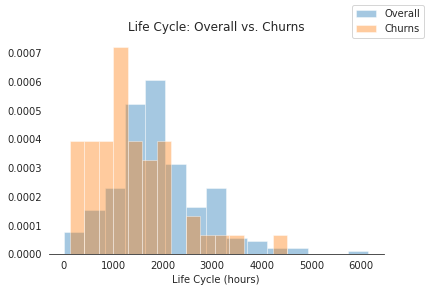

In [15]:
# 作柱状图对比流失用户和全体用户的生命周期
sns.set_style('white')

f, ax = plt.subplots()

sns.distplot(df_userlife.toPandas().lifecycle, bins = 15, kde = False, norm_hist = True)
sns.distplot(df_userlife.toPandas().query('churn == "1"').lifecycle, bins = 15, kde = False, norm_hist = True)

plt.title('Life Cycle: Overall vs. Churns')
plt.xlabel('Life Cycle (hours)')
f.legend(labels=['Overall','Churns'])

sns.despine(left=True);

> 可见流失用户生命周期偏短峰值在1000小时左右，相对整体用户（峰值约2000小时）明显偏短

#### 2. 性别 `gender`

In [16]:
df_gender = spark.sql('''
        SELECT is_churn, gender, userId
        FROM df_table
        GROUP BY is_churn, gender, userId
        ''')

df_gender.show(5)

+--------+------+------+
|is_churn|gender|userId|
+--------+------+------+
|       0|     F|100010|
|       0|     M|200002|
|       1|     M|   125|
|       0|     F|   124|
|       1|     M|    51|
+--------+------+------+
only showing top 5 rows



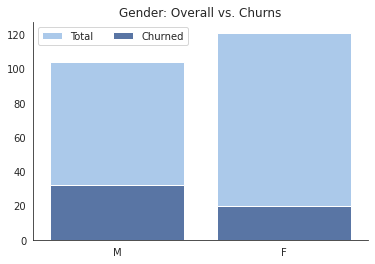

In [17]:
# 比较各自性别内的用户流失比例
f, ax = plt.subplots()

# Plot for total
sns.set_color_codes('pastel')
sns.countplot(x = 'gender', data = df_gender.toPandas(), label='Total', color='b')

# Plot for churned
sns.set_color_codes('deep')
sns.countplot(x='gender', data = df_gender.toPandas()[df_gender.toPandas().is_churn == 1], label='Churned', color='b')

# Decoration
ax.legend(ncol=2, frameon=True)
ax.set(title = 'Gender: Overall vs. Churns', ylabel='', xlabel='');
sns.despine()

> 可观察到男性用户流失的比率更高

#### 3. 不同性别间流失时间差异

In [18]:
df_lifecycle_gender = spark.sql('''
        SELECT gender, ROUND(MAX(ts - registration)/1000/3600) AS lifecycle
        FROM df_table
        WHERE is_churn = 1
        GROUP BY gender, userId
        ''')

df_lifecycle_gender.show(5)

+------+---------+
|gender|lifecycle|
+------+---------+
|     M|   1712.0|
|     M|    467.0|
|     F|   2658.0|
|     M|   2042.0|
|     M|   1295.0|
+------+---------+
only showing top 5 rows



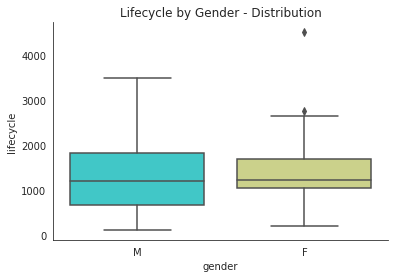

In [19]:
sns.set_color_codes('pastel')
sns.boxplot(data = df_lifecycle_gender.toPandas(), x = 'gender', y = 'lifecycle', palette='rainbow')
plt.title('Lifecycle by Gender - Distribution')
sns.despine();

> 中位数相近，相对来说女性在决定取消服务前会等待更长一段时间

#### 4. `paid` vs. `free`

In [20]:
df_level = spark.sql('''
        SELECT t2.userId, t2.last_ts, t1.level, t1.is_churn
        FROM 
        df_table AS t1 RIGHT JOIN
            (SELECT userId, MAX(ts) AS last_ts FROM df_table GROUP BY userId) AS t2
            ON t1.userId = t2.userId AND t1.ts = t2.last_ts
        ORDER BY userId, last_ts
        ''').dropDuplicates()

df_level.show(5)

+------+-------------+-----+--------+
|userId|      last_ts|level|is_churn|
+------+-------------+-----+--------+
|    10|1542631788000| paid|       0|
|   100|1543587349000| paid|       0|
|100001|1538498205000| free|       1|
|100002|1543799476000| paid|       0|
|100003|1539274781000| free|       1|
+------+-------------+-----+--------+
only showing top 5 rows



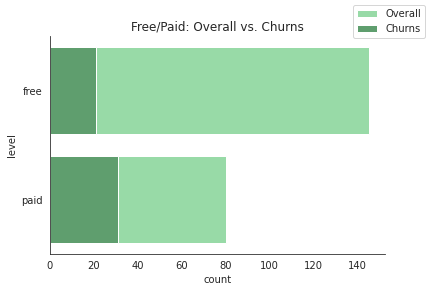

In [21]:
f, ax = plt.subplots()

sns.set_color_codes('pastel')
sns.countplot(y = 'level', data = df_level.toPandas(), color = 'g')

sns.set_color_codes('deep')
sns.countplot(y = 'level', data = df_level.toPandas()[df_level.toPandas()['is_churn'] == 1], color = 'g')
plt.title('Free/Paid: Overall vs. Churns')
f.legend(labels=['Overall','Churns'])

sns.despine();

> 可观察到付费用户流失的比例更高

#### 5. 用户活动情况 `page` 分析
从用户注册之日起，以周为单位汇总各项活动数量，并对比取消服务用户和其他用户。  
以周为单位而非小时或日，会使曲线更平滑更易于对比。

In [22]:
# 挑选可能有影响的活动
features  = ('NextSong','Thumbs Up','Thumbs Down','Add Friend','Add to Playlist','Downgrade','Roll Advert')

In [23]:
# 分析非流失用户
df_page_0 = spark.sql('''
        SELECT weeks, page, AVG(COUNT) AS count_nchurn
        FROM
        (SELECT userId, ROUND(period/24/7) AS weeks, page, COUNT(*) AS count
        FROM df_table
        WHERE is_churn = 0
            AND page IN ('NextSong','Thumbs Up','Thumbs Down','Add Friend','Add to Playlist','Downgrade','Roll Advert')
        GROUP BY userId, weeks, page)
        GROUP BY weeks, page
        ''')

In [24]:
# 分析流失用户
df_page_1 = spark.sql('''
        SELECT weeks, page, AVG(COUNT) AS count_churn
        FROM
        (SELECT userId, ROUND(period/24/7) AS weeks, page, COUNT(*) AS count
        FROM df_table
        WHERE is_churn = 1
            AND page IN ('NextSong','Thumbs Up','Thumbs Down','Add Friend','Add to Playlist','Downgrade','Roll Advert')
        GROUP BY userId, weeks, page)
        GROUP BY weeks, page
        ''')

In [25]:
# 合并上述分析结果
df_page = pd.merge(df_page_0.toPandas(), df_page_1.toPandas(), on = ['weeks','page'])

In [26]:
df_page = pd.melt(df_page, id_vars=['weeks','page'], var_name='is_churn', value_name='count').sort_values(['weeks','page'])
df_page.head()

,weeks,page,is_churn,count
23,0.0,Add Friend,count_nchurn,2.428571
194,0.0,Add Friend,count_churn,1.000000
165,0.0,Add to Playlist,count_nchurn,2.583333
336,0.0,Add to Playlist,count_churn,1.000000
104,0.0,NextSong,count_nchurn,79.571429


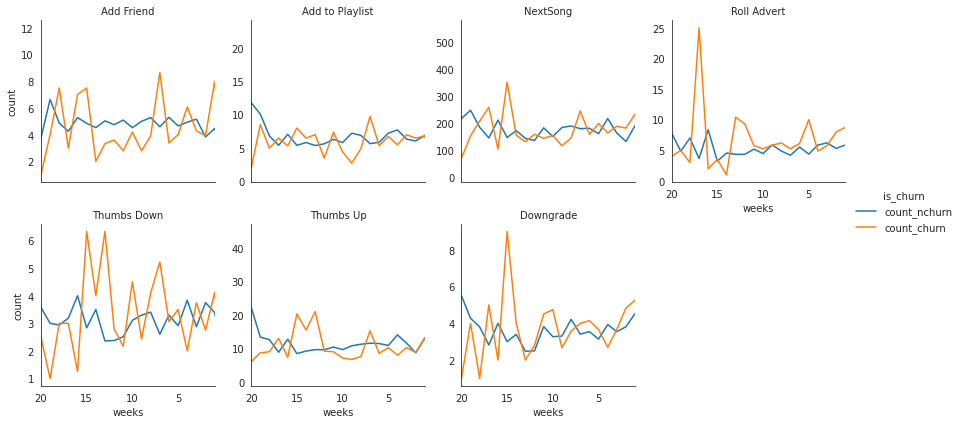

In [27]:
# 作拆线图。因为根据前述生命周期分析，绝大多数流失用户在 20 周内就取消了服务，所以这里我们把 x 轴限制在家 20 周以内，以避免后续因流失用户
# 数量不足而对分析结果造成偏差
g = sns.FacetGrid(data = df_page, col = 'page', hue = 'is_churn', col_wrap = 4, sharey = False, xlim = 20, legend_out = True)
g.map(sns.lineplot, 'weeks', 'count')
g.add_legend()
g.set_titles('{col_name}');

> 观察到有几项差别较明显：`Add Friend` `Roll Advert` `Thumbs Down` `Thumbs Up` `Downgrade`

#### 6. 听过的歌手数量对比

In [39]:
df_artist = spark.sql('''
        SELECT AVG(t. artists) AS artists, t.is_churn
        FROM
        (SELECT userId, COUNT(artist) AS artists, is_churn
        FROM df_table
        GROUP BY is_churn, userId) AS t
        GROUP BY t.is_churn
        ''')

df_artist.show(5)

+------------------+--------+
|           artists|is_churn|
+------------------+--------+
| 699.8846153846154|       1|
|1108.1734104046243|       0|
+------------------+--------+



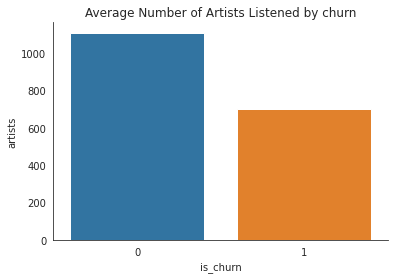

In [137]:
sns.set_color_codes('pastel')
sns.barplot(x = 'is_churn', y = 'artists', data = df_artist.toPandas())
plt.title('Average Number of Artists Listened by churn')

sns.despine();

> 观察到流失用户平均听过的歌手数量比较低

#### 7. 用户 session 数量统计

In [41]:
df_session = spark.sql('''
        SELECT t.userId, AVG(t.sessions) AS sessions, t.is_churn
        FROM
        (SELECT userId, COUNT(sessionId) AS sessions, MAX(is_churn) AS is_churn
        FROM df_table
        GROUP BY userId) AS t
        GROUP BY t.userId, t.is_churn
        ''')
df_session.show(5)

+------+--------+--------+
|userId|sessions|is_churn|
+------+--------+--------+
|100010|   381.0|       0|
|200002|   474.0|       0|
|   125|    11.0|       1|
|   124|  4825.0|       0|
|    51|  2464.0|       1|
+------+--------+--------+
only showing top 5 rows



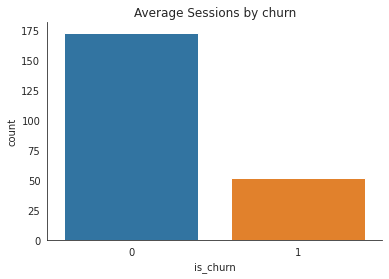

In [138]:
sns.countplot(data = df_session.toPandas(), x = 'is_churn')
plt.title('Average Sessions by churn')
sns.despine();

> 可观察到到流失用户 session 数明显低于未流失用户

#### 8. 每个session内歌曲播放的总时长

In [43]:
df_length = spark.sql('''
        SELECT t.userId, AVG(t.length) AS length, t.is_churn
        FROM
        (SELECT userId, sessionId, SUM(length) AS length, MAX(is_churn) AS is_churn
        FROM df_table
        WHERE page = 'NextSong'
        GROUP BY userId, sessionId) AS t
        GROUP BY t.userId, t.is_churn
        ORDER BY t.userId
        ''')
df_length.show(5)

+------+------------------+--------+
|userId|            length|is_churn|
+------+------------------+--------+
|    10|27811.062084999994|       0|
|   100|19790.525193823534|       0|
|100001|      8768.4355375|       1|
|100002|12389.979524999995|       0|
|100003| 6153.209660000001|       1|
+------+------------------+--------+
only showing top 5 rows



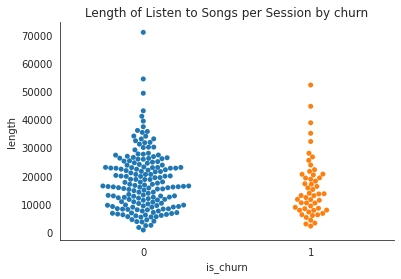

In [140]:
sns.swarmplot(data = df_length.toPandas(), x = 'is_churn', y = 'length');
plt.title('Length of Listen to Songs per Session by churn')
sns.despine();

> 可观察到流失用户每个 session 内歌曲播放总时长也较少

# 特征工程
### 挑选上一部分分析过的 `page` 相关变量，提取为特征

In [45]:
df_pages = spark.sql('''
        SELECT userId, page, COUNT(*) AS count
        FROM df_table
        WHERE page In ('NextSong','Thumbs Up','Thumbs Down','Add Friend','Add to Playlist','Downgrade','Roll Advert')
        GROUP BY userId, page
        ORDER BY userId
        ''')

df_pages = df_pages.groupby('userId').pivot('page').sum('count').fillna(0)
df_pages.show(5)

+------+----------+---------------+---------+--------+-----------+-----------+---------+
|userId|Add Friend|Add to Playlist|Downgrade|NextSong|Roll Advert|Thumbs Down|Thumbs Up|
+------+----------+---------------+---------+--------+-----------+-----------+---------+
|    10|        12|              9|        7|     673|          1|          4|       37|
|   100|        49|             61|       30|    2682|         25|         27|      148|
|100001|         2|              3|        0|     133|         14|          2|        8|
|100002|         1|              5|        2|     195|          3|          0|        5|
|100003|         0|              2|        0|      51|          9|          0|        3|
+------+----------+---------------+---------+--------+-----------+-----------+---------+
only showing top 5 rows



### 补充一些其它变量并提取为特征

In [46]:
# 统计各用户听过的 artists 数量
df_artists = spark.sql('''
        SELECT userId, COUNT(artist) AS artists
        FROM df_table
        GROUP BY userId
        ''')
df_artists.show(5)

+------+-------+
|userId|artists|
+------+-------+
|100010|    275|
|200002|    387|
|   125|      8|
|    51|   2111|
|   124|   4079|
+------+-------+
only showing top 5 rows



In [47]:
# 将 gender 从 M/F 转换为 1/0 
cvt_gender = udf(lambda x: 1 if x == 'M' else 0, IntegerType())
df_gender = df_gender.withColumn('gender', cvt_gender('gender'))

In [48]:
# 将 level 从 paid/free 转换为 1/0 
cvt_level = udf(lambda x: 1 if x == 'paid' else 0, IntegerType())
df_level = df_level.withColumn('level', cvt_level('level'))

### 合并所有特征和标签

In [49]:
data = df_userlife.select('userId','lifecycle',col('churn').alias('label')) \
        .join(df_gender.select('userId','gender'), on='userId', how='outer') \
        .join(df_level.select('userId','level'), on='userId', how='outer') \
        .join(df_pages, on = 'userId', how='outer') \
        .join(df_artists.select('userId','artists'), on='userId', how='outer') \
        .join(df_session.select('userId','sessions'), on = 'userId', how='outer') \
        .join(df_length.select('userId','length'), on='userId', how='outer') \
        .fillna(0)

data.show(1)

+------+---------+-----+------+-----+----------+---------------+---------+--------+-----------+-----------+---------+-------+--------+-----------------+
|userId|lifecycle|label|gender|level|Add Friend|Add to Playlist|Downgrade|NextSong|Roll Advert|Thumbs Down|Thumbs Up|artists|sessions|           length|
+------+---------+-----+------+-----+----------+---------------+---------+--------+-----------+-----------+---------+-------+--------+-----------------+
|100010|   1335.0|    0|     0|    0|         4|              7|        0|     275|         52|          5|       17|    275|   381.0|9562.985335714286|
+------+---------+-----+------+-----+----------+---------------+---------+--------+-----------+-----------+---------+-------+--------+-----------------+
only showing top 1 row



In [50]:
# 检查合并结果
data.count()

225

# 建模

将完整数据集分成训练集、测试集和验证集。 
使用几种学过的机器学习方法进行训练，并评价不同机方法的结果。

这里选用 F1 score 作为主要优化指标， 因为我们希望在准确率和召回率间取得平衡，即希望尽可能不漏掉可能流失的用户，又不希望把优惠额度浪费在太多本没有流失风险的用户上。而F1 Score在平衡二者上有较好的参考意义。

另外训练时间也是一个重要的参考指标，尤其是我们要处理的数据量非常大，以过长的训练时间（也意味着更多的计算资源）来换取F1 Score的少量提升并不划算。

In [52]:
# 检查变量数据格式是否均为数字
data.printSchema()

root
 |-- userId: string (nullable = true)
 |-- lifecycle: double (nullable = false)
 |-- label: integer (nullable = true)
 |-- gender: integer (nullable = true)
 |-- level: integer (nullable = true)
 |-- Add Friend: long (nullable = true)
 |-- Add to Playlist: long (nullable = true)
 |-- Downgrade: long (nullable = true)
 |-- NextSong: long (nullable = true)
 |-- Roll Advert: long (nullable = true)
 |-- Thumbs Down: long (nullable = true)
 |-- Thumbs Up: long (nullable = true)
 |-- artists: long (nullable = true)
 |-- sessions: double (nullable = false)
 |-- length: double (nullable = false)



## 数据预处理
### Vector Assembler

In [53]:
cols = ['lifecycle', 'gender', 'level', 'Add Friend', 'Add to Playlist', 'Downgrade', \
        'NextSong', 'Roll Advert', 'Thumbs Down', 'Thumbs Up', 'artists', 'sessions', 'length']

assembler = VectorAssembler(inputCols = cols, outputCol = 'NumFeatures')
data = assembler.transform(data)

### Normalize and Scale Vectors

In [54]:
scaler = StandardScaler(inputCol = 'NumFeatures', outputCol = 'features', withStd = True)
scalerModel = scaler.fit(data)
data = scalerModel.transform(data)

## 划分训练集、测试集和验证集库 Train, Test and Validation

In [56]:
# 划分比例 train:validation:test = 8:1:1
train, rest = data.randomSplit([.8, .2], seed = 42)
validation, test = rest.randomSplit([.5, .5], seed = 42)

# 将数据集存在内存中，以加快后续程序运行的速度。
train.cache()
validation.cache()
test.cache()

DataFrame[userId: string, lifecycle: double, label: int, gender: int, level: int, Add Friend: bigint, Add to Playlist: bigint, Downgrade: bigint, NextSong: bigint, Roll Advert: bigint, Thumbs Down: bigint, Thumbs Up: bigint, artists: bigint, sessions: double, length: double, NumFeatures: vector, features: vector]

## 定义 Baseline

In [57]:
# 假设全部用户标记为取消服务，计算其 F1-Score
baseline_1 = test.withColumn('prediction',lit(1.0))
evaluator = MulticlassClassificationEvaluator()
acc_1 = evaluator.evaluate(baseline_1, {evaluator.metricName:'accuracy'})
f1_1 = evaluator.evaluate(baseline_1)

In [58]:
# 假设全部用户标记为未取消服务，计算其 F1-Score
baseline_0 = test.withColumn('prediction',lit(0.0))
evaluator = MulticlassClassificationEvaluator()
acc_0 = evaluator.evaluate(baseline_0, {evaluator.metricName:'accuracy'})
f1_0 = evaluator.evaluate(baseline_0)

In [75]:
print(f'Baseline F1-Score: \nAs all users labeled as churn: {f1_1} \nAs all users labeled as not churn: {f1_0} \
        \n\nBaseline Accuracy: \nAs all users labeled as churn: {acc_1} \nAs all users labeled as not churn: {acc_0}')

Baseline F1-Score: 
As all users labeled as churn: 0.0808080808080808 
As all users labeled as not churn: 0.6805555555555557         

Baseline Accuracy: 
As all users labeled as churn: 0.2222222222222222 
As all users labeled as not churn: 0.7777777777777778


> 我们把 `假设所有用户都没有取消服务` 设置为 Baseline，其 F1-Score为 0.681

## 训练
使用 5 种不同模型进行训练，并计算其运行时间、准确率和 F1-Score  
候选模型：`Logistic Regression` `Logistic Regression` `Gradient-Boosted Trees` `Support Vector Machines` `Naive Bayes`

In [77]:
# 使用 train 和 validation 数据集，依此训练 5 个模型 
models = {'Logistic Regression': LogisticRegression(),
     'Random Forest': RandomForestClassifier(),
     'Gradient-Boosted Trees': GBTClassifier(),
     'Support Vector Machines': LinearSVC(),
     'Naive Bayes': NaiveBayes()}

compare = dict()

for md in models:
    start_time = time.time()
    model = models[md].fit(train)

    runtime = time.time() - start_time

    results = model.transform(validation)
    accuracy = MulticlassClassificationEvaluator(metricName='accuracy').evaluate(results)
    f1 = MulticlassClassificationEvaluator().evaluate(results)

    compare[md] = {'runtime': runtime, 'accuracy': accuracy, 'f1': f1}

## 模型选择
列表比较5个模型的训练结果，并与 Baseline 进行对比

In [100]:
# 在结果中并入 Baseline
compare.update({'Baseline': {'runtime': '-','accuracy': acc_0, 'f1': f1_0}})

In [107]:
# 显示结果并按照 F1-Score 和 Runtime 排序
df_compare = pd.DataFrame(compare).transpose().sort_values(['f1','runtime'], ascending = [False, True])
df_compare

,accuracy,f1,runtime
Random Forest,0.857143,0.839827,36.0904
Logistic Regression,0.857143,0.839827,233.662
Gradient-Boosted Trees,0.714286,0.72619,358.514
Baseline,0.777778,0.680556,-
Naive Bayes,0.714286,0.595238,3.89333
Support Vector Machines,0.714286,0.595238,686.562


> 论准确度和 F1-Score `Logistic Regression` 和 `Random Forest` 最高，而 `Random Forest`用时更短，故选择`Random Forest`模型，并作进一步调优

### 参数调节
对了Random Forest 模型尝试不同参数

In [67]:
# 设置需要调节的参数
gbt = RandomForestClassifier()

paramGrid = ParamGridBuilder() \
    .addGrid(gbt.maxDepth,[5, 7,10]) \
    .addGrid(gbt.numTrees,[20, 30, 50]) \
    .build()

crossval = CrossValidator(estimator=gbt,
                          estimatorParamMaps=paramGrid,
                          evaluator=MulticlassClassificationEvaluator(),
                          numFolds=3)

In [68]:
# 训练得出最优模型，并在测试集上生成预测
best = GBTClassifier(maxIter=10, maxDepth=5)

start_time = time.time()
cvModel = crossval.fit(train)
runtime_best = time.time() - start_time

cvModel.avgMetrics
results = cvModel.transform(test)
evaluator = MulticlassClassificationEvaluator(predictionCol = 'prediction')
f1_best = evaluator.evaluate(results,{evaluator.metricName:'f1'})

print(f'Final Results:\nTraining time(seconds): {runtime_best} seconds \nF1-Score on Validation set: {f1_best}')

Final Results:
Training time(seconds): 1914.5231359004974 seconds 
F1-Score on Validation set: 0.7901234567901235


> 最终在测试集上的结果 F1-Score = 0.790，对比 Baseline 的 0.681 仍然有 16% 的优势

In [468]:
# 保存模型以备将来使用
cvModel.save('trainedModel')

# 特征分析
分析各个特征所占比重

In [141]:
fi = cvModel.bestModel.featureImportances.values

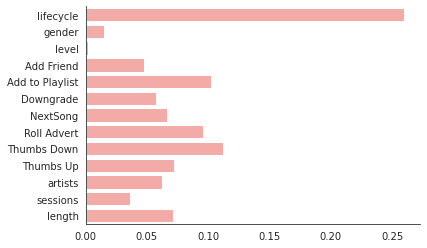

In [142]:
sns.set_color_codes('pastel')
y = np.arange(len(cols))
sns.barplot(y=cols, x=fi, color = 'r')
sns.despine();

> `lifecycle` 占压倒性优势，其次是 `Thumb Down` 和 `Add to Playlist`，`gender` 和 `level` 影响最小

# 结论分析
- 根据前述情况可以看出，对用户流失影响最大的因素为 `lifecycle`，亦即注册时长，而一般猜测的因素如播放数量和时间、是否付费，以及社交频度等，虽然也是影响因素，相较之下并没有体现出想象中的影响力，尤其是性别和账户等级，影响力非常小。多数用户在2000小时左右就取消了服务。
- 按照这一结论的话，我们应该在用户注册满2000小时左右就给他们提供优惠券。 

### 局限
- 而经过调参后的最优模型 Random Forest 得出的 F1-Score 0.790 并不是一个很好的结果，只比 Baseline 高出 16%。可能的原因是，参与分析的子集中一共只包含225个用户，这对训练来说可能是不够的。如果将最终模型运用到完整数据集中，应该能得到好的结果。

- `Downgrade`应该是一个很重要的因素，但在此次特征分析中占比不算高，应该跟用户数太少有关系。而在完整数据集中针对所有 `Downgrade` 用户单独作分析，可能能够得到更有意义的结论。

- 未取消服务的用户可能包括两种情况：重度用户和注册之后很少使用的用户，不区别这二者的话，可能会对我们的分析结果造成偏差。

- 另外还可以考虑针对用户取消服务之前几天、几周内的行为作更精细化的分析，也许能够找出某些行为模式。

### 项目总结
- 此次项目涵盖了课程所学从数据清理、可视化分析、Spark、到机器学习的完整过程。课程前期的一些内容，到现在印象已经淡化，趁这个项目我进行了复习并进行了知识整合。
- 与以前项目相比，本项目的一个特点是：花费在模型训练上的时间非常长。尤其在调参时，如果开始时选择的参数不佳，反复尝试更是花费成倍的时间，这也让我更直观地认识到数据质量、算法和模型选择对一个项目所需时间和资源的影响。

### Github代码库
https://github.com/liyapink/Sparkify/

# 参考
- https://blog.csdn.net/SunflowerLuck/article/details/
- https://github.com/linpingyu/Sparkify